# Abstract

Суть решения - поиск как можно большего числа клик (полных связных подграфов) в исходной матрице, принимаемой в виде графа и последующий "добор" всех оставшихся с минимизацией итоговой мощности объединения.

**Обоснование идеи**

Заметим, что после упрощения задачи самый простой способ решения - проход по всем ячейкам попарных пересечений (выше диагонали) и учет для каждой пары новых элементов в количестве мощности этого пересечения.

Рассмотрим набор множеств такого вида: \\

$\begin{pmatrix}
x & 2 & 3 & 4 \\
2 & x & 3 & 6 \\
3 & 3 & x & 2 \\
4 & 6 & 2 & x \\
\end{pmatrix}$ 

Скажем, что здесь задана клика из 3 элементов, которую можно учесть 2 раза (минимальное значение в выбранных ячейках). Учет этих же элементов лобовым методом, описанным выше, положит в каждое из 4 множеств по 2 * 3 уникальных элемента, и тогда всего их будет задействовано 24, в то время как нахождение этой клики запишет всего по 2 элемента, т.к. мы учитываем совпадение вершин во всех множествах из найденной клики.

Из этих соображений можно вывести формулу, показывающую сэкономленную мощность объединения из-за выбора клики:

$Economy = arr[i, j]_{min}*(2\frac{n(n-1)}{2}-n) = arr[i, j]_{min}*(n^2-2n)$

Из этого следует, что **нахождение клик действительно дает большой выигрыш по мощности**.

In [ ]:
# Импорт библиотек

import pandas as pd
import numpy as np
import torch
from copy import deepcopy
from numba import jit, njit
import json
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Чтение в pandas

name = 'triplets_all.csv'
raw = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/{name}')
n = int(raw.size ** 0.5)

raw

,ids,intersize
0,0_0,46
1,0_1,5
2,0_2,2
3,0_3,14
4,0_4,10
...,...,...
385876,875_876,0
385877,875_877,0
385878,876_876,43
385879,876_877,3


In [ ]:
# Преобразование в матричный вид

cur = 0
data = np.empty((n, n), dtype=int)
for i in range(0, n):
    for j in range(i, n):
        data[i][j] = raw['intersize'][cur]
        data[j][i] = raw['intersize'][cur]
        cur += 1
data

array([[ 46,   5,   2, ...,   0,   0,   0],
       [  5, 121,   8, ...,   0,   0,   0],
       [  2,   8,  43, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  40,   0,   0],
       [  0,   0,   0, ...,   0,  43,   3],
       [  0,   0,   0, ...,   0,   3,  72]])

In [ ]:
# Сброс клик перед поиском новых
res = [set() for i in range(n)]
cur = 0
data_cp = deepcopy(data)

# Инициализация функции конвертации циклов в итоговую форму
def cycles_to_res(cycles, len):
    global cur
    for i in cycles[:len]:
        for cnt in range(i[-1]):
            for j in i[:-1]:
                res[j].add(cur)
            cur += 1

# Метод поиска клик фиксированного размера в порядке, минимизирующем мощность объединения

**Определение порядка рассмотрения вершин**

Заметим, что поиск клик напрямую по имеющемуся графу - идея неоптимальная в силу неудачного начального расположения мощностей пересечений друг относительно друга.

Вместо этого будем рассматривать элементы через оператор *diag*, определяющий следующий оптимальный элемент.

Взаимное расположение можно задавать разными способами, но наилучших результатов получилось добиться на поиске клик размера 5 по точкам 0-100; 12-112; 24-124 ... и последующем полном поиске клик размера 4 и 3.

Данный выбор обусловлен предположением о том, что можно получить достаточный выигрыш на кликах небольшого размера, но взятых большее число раз.

In [ ]:
# Создание diag для перехода в нужном порядке

h = np.empty(n, dtype=int)
for i in range(0, n):
    h[i] = 0
    for j in range(0, n):
        if i == j: continue
        if data[i, j]: h[i] += 1
#h = np.sort(h)

diag = np.argsort(h)[::-1][:n]


**Поиск клик заданного размера**

В данной идее мы рассматриваем фиксированный набор размеров клик, поэтому вместо универсального итеративного или рекурсивного варианта оправдан следующий подход: можно "захардкодить" поиск по интресующих нас размерам, который по сравнению с другими вариантами даст сильный выигрыш в скорости.

In [ ]:
@njit()
def find_cycles_5(data_cp, cycles):
    size = 100
    step = 10
    cycles_len = 0
    for cnt in range(0, n - size + 1, step):
        if cnt % 100 == 0: print(cnt)
        for cur_0_c in range(cnt, cnt+size):
            for cur_1_c in range(cur_0_c + 1, cnt+size):
                for cur_2_c in range(cur_1_c + 1, cnt+size):
                    for cur_3_c in range(cur_2_c + 1, cnt+size):
                        for cur_4_c in range(cur_3_c + 1, cnt+size):
                            cur_0 = diag[cur_0_c]
                            cur_1 = diag[cur_1_c]
                            cur_2 = diag[cur_2_c]
                            cur_3 = diag[cur_3_c]
                            cur_4 = diag[cur_4_c]
                            if data_cp[cur_0, cur_1] and data_cp[cur_0, cur_2] and data_cp[cur_0, cur_3] and data_cp[cur_0, cur_4] and data_cp[cur_1, cur_2] and data_cp[cur_1, cur_3] and data_cp[cur_1, cur_4] and data_cp[cur_2, cur_3] and data_cp[cur_2, cur_4] and data_cp[cur_3, cur_4]:
                                cycles_len += 1
                                cycles[cycles_len - 1][0] = cur_0
                                cycles[cycles_len - 1][1] = cur_1
                                cycles[cycles_len - 1][2] = cur_2
                                cycles[cycles_len - 1][3] = cur_3
                                cycles[cycles_len - 1][4] = cur_4
                            while data_cp[cur_0, cur_1] and data_cp[cur_0, cur_2] and data_cp[cur_0, cur_3] and data_cp[cur_0, cur_4] and data_cp[cur_1, cur_2] and data_cp[cur_1, cur_3] and data_cp[cur_1, cur_4] and data_cp[cur_2, cur_3] and data_cp[cur_2, cur_4] and data_cp[cur_3, cur_4]:
                                cycles[cycles_len - 1][-1] += 1
                                data_cp[cur_0][cur_1] -= 1
                                data_cp[cur_1][cur_0] -= 1
                                data_cp[cur_0][cur_2] -= 1
                                data_cp[cur_2][cur_0] -= 1
                                data_cp[cur_0][cur_3] -= 1
                                data_cp[cur_3][cur_0] -= 1
                                data_cp[cur_0][cur_4] -= 1
                                data_cp[cur_4][cur_0] -= 1
                                data_cp[cur_1][cur_2] -= 1
                                data_cp[cur_2][cur_1] -= 1
                                data_cp[cur_1][cur_3] -= 1
                                data_cp[cur_3][cur_1] -= 1
                                data_cp[cur_1][cur_4] -= 1
                                data_cp[cur_4][cur_1] -= 1
                                data_cp[cur_2][cur_3] -= 1
                                data_cp[cur_3][cur_2] -= 1
                                data_cp[cur_2][cur_4] -= 1
                                data_cp[cur_4][cur_2] -= 1
                                data_cp[cur_3][cur_4] -= 1
                                data_cp[cur_4][cur_3] -= 1
    return cycles_len


print(f'Searching cycles of length 5')
cycles_5 = np.zeros((500000, 6), dtype=int)
cycles_5_len = find_cycles_5(data_cp, cycles_5)
cycles_to_res(cycles_5, cycles_5_len)
print(f'Added cycles for len 5:{ cycles_5_len}')



@njit()
def find_cycles_4(data_cp, cycles):
    size = 878
    step = 5
    cycles_len = 0
    for cnt in range(0, n - size + 1, step):
        if cnt % 100 == 0: print(cnt)
        for cur_0_c in range(cnt, cnt+size):
            for cur_1_c in range(cur_0_c + 1, cnt+size):
                for cur_2_c in range(cur_1_c + 1, cnt+size):
                    for cur_3_c in range(cur_2_c + 1, cnt+size):
                        cur_0 = diag[cur_0_c]
                        cur_1 = diag[cur_1_c]
                        cur_2 = diag[cur_2_c]
                        cur_3 = diag[cur_3_c]
                        if data_cp[cur_0, cur_1] and data_cp[cur_0, cur_2] and data_cp[cur_0, cur_3] and data_cp[cur_1, cur_2] and data_cp[cur_1, cur_3] and data_cp[cur_2, cur_3]:
                            cycles_len += 1
                            cycles[cycles_len - 1][0] = cur_0
                            cycles[cycles_len - 1][1] = cur_1
                            cycles[cycles_len - 1][2] = cur_2
                            cycles[cycles_len - 1][3] = cur_3
                        while data_cp[cur_0, cur_1] and data_cp[cur_0, cur_2] and data_cp[cur_0, cur_3] and data_cp[cur_1, cur_2] and data_cp[cur_1, cur_3] and data_cp[cur_2, cur_3]:
                            cycles[cycles_len - 1][-1] += 1
                            data_cp[cur_0][cur_1] -= 1
                            data_cp[cur_1][cur_0] -= 1
                            data_cp[cur_0][cur_2] -= 1
                            data_cp[cur_2][cur_0] -= 1
                            data_cp[cur_0][cur_3] -= 1
                            data_cp[cur_3][cur_0] -= 1
                            data_cp[cur_1][cur_2] -= 1
                            data_cp[cur_2][cur_1] -= 1
                            data_cp[cur_1][cur_3] -= 1
                            data_cp[cur_3][cur_1] -= 1
                            data_cp[cur_2][cur_3] -= 1
                            data_cp[cur_3][cur_2] -= 1
    return cycles_len


print(f'Searching cycles of length 4')
cycles_4 = np.zeros((500000, 5), dtype=int)
cycles_4_len = find_cycles_4(data_cp, cycles_4)
cycles_to_res(cycles_4, cycles_4_len)
print(f'Added cycles for len 4:{ cycles_4_len}')



@njit()
def find_cycles_3(data_cp, cycles):
    size = 878
    step = 5
    cycles_len = 0
    for cnt in range(0, n - size + 1, step):
        if cnt % 100 == 0: print(cnt)
        for cur_0_c in range(cnt, cnt+size):
            for cur_1_c in range(cur_0_c + 1, cnt+size):
                for cur_2_c in range(cur_1_c + 1, cnt+size):
                    cur_0 = diag[cur_0_c]
                    cur_1 = diag[cur_1_c]
                    cur_2 = diag[cur_2_c]
                    if data_cp[cur_0, cur_1] and data_cp[cur_0, cur_2] and data_cp[cur_1, cur_2]:
                        cycles_len += 1
                        cycles[cycles_len - 1][0] = cur_0
                        cycles[cycles_len - 1][1] = cur_1
                        cycles[cycles_len - 1][2] = cur_2
                    while data_cp[cur_0, cur_1] and data_cp[cur_0, cur_2] and data_cp[cur_1, cur_2]:
                        cycles[cycles_len - 1][-1] += 1
                        data_cp[cur_0][cur_1] -= 1
                        data_cp[cur_1][cur_0] -= 1
                        data_cp[cur_0][cur_2] -= 1
                        data_cp[cur_2][cur_0] -= 1
                        data_cp[cur_1][cur_2] -= 1
                        data_cp[cur_2][cur_1] -= 1
    return cycles_len


print(f'Searching cycles of length 3')
cycles_3 = np.zeros((500000, 4), dtype=int)
cycles_3_len = find_cycles_3(data_cp, cycles_3)
cycles_to_res(cycles_3, cycles_3_len)
print(f'Added cycles for len 3:{ cycles_3_len}')

Searching cycles of length 5
0
100
200
300
400
500
600
700
Added cycles for len 5:23268
Searching cycles of length 4
0
Added cycles for len 4:132715
Searching cycles of length 3
0
Added cycles for len 3:48559


**Жадный алгоритм для оставшихся пересечений**

На данном этапе мы можем гарантировать, что клик размера 3 и 4 (ровно как и любой другой размерности выше) в нашем графе уже не существует, они все взяты, а поэтому нам не остается ничего, кроме как для каждого оставшегося непустого персечения учесть соответствующие число новых элементов в оба множества.

**ВЫВОД**

Данный метод наивен, в первую очередь в определении оптимального порядка рассмотрения ячеек. Определенными экспериментами с параметрами такой системы можно достичь мощности, близкой к 600к, но сильно ниже опуститься уже проблематично - **требуется более умное разделение на группы**.

# Метод с кластеризацией

Вместо фиксированного перебора клик можно произвести кластеризацию всех множеств, **распределив их в небольшие группы**, имеющие удобные пересечения, по которым искать клики и быстрее, и полезнее.

In [ ]:
# Получение матрицы с метрикой

mtr = deepcopy(data)
mtr = mtr.astype(float)
for i in range(0, n):
    for j in range(0, n):
        if mtr[i, j] == 0:
            mtr[i, j] = 5
        else:
            mtr[i, j] = 1 / (mtr[i, j] ** 0.2)
mtr

array([[0.46499516, 0.72477966, 0.87055056, ..., 5.        , 5.        ,
        5.        ],
       [0.72477966, 0.38321538, 0.65975396, ..., 5.        , 5.        ,
        5.        ],
       [0.87055056, 0.65975396, 0.47130962, ..., 5.        , 5.        ,
        5.        ],
       ...,
       [5.        , 5.        , 5.        , ..., 0.47817625, 5.        ,
        5.        ],
       [5.        , 5.        , 5.        , ..., 5.        , 0.47130962,
        0.80274156],
       [5.        , 5.        , 5.        , ..., 5.        , 0.80274156,
        0.4251415 ]])

Обзор зависимости число совпадающих ячеек метрики от значение самой матрики

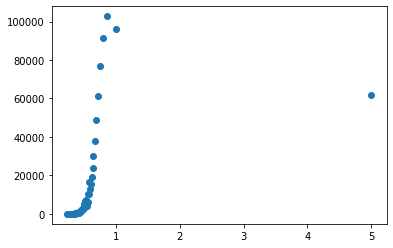

In [ ]:
x = dict()
for i in range(n):
    for j in range(n):
        g = mtr[i, j] * 100 // 1 / 100
        if g in x.keys():
            x[g] += 1
        else:
            x[g] = 1
fig, ax = plt.subplots()
plt.scatter(list(x.keys()), list(x.values()))

In [ ]:
def do_clustering(mtr, clusters):
    cluster = AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='ward')
    clust_res = cluster.fit_predict(mtr)
    groups = []
    groups_len = []
    for i in range(0, clusters):
        c = []
        for j in range(0, n):
            if clust_res[j] == i:
                c.append(j)
        print(f'Added sets for {i}-th group : {len(c)}')
        groups.append(np.array(c))
        groups_len.append(len(c))
    return groups, groups_len

groups, groups_len = do_clustering(mtr, 30)

Added sets for 0-th group : 13
Added sets for 1-th group : 17
Added sets for 2-th group : 17
Added sets for 3-th group : 15
Added sets for 4-th group : 23
Added sets for 5-th group : 185
Added sets for 6-th group : 2
Added sets for 7-th group : 77
Added sets for 8-th group : 24
Added sets for 9-th group : 48
Added sets for 10-th group : 3
Added sets for 11-th group : 7
Added sets for 12-th group : 41
Added sets for 13-th group : 22
Added sets for 14-th group : 64
Added sets for 15-th group : 30
Added sets for 16-th group : 13
Added sets for 17-th group : 7
Added sets for 18-th group : 12
Added sets for 19-th group : 9
Added sets for 20-th group : 3
Added sets for 21-th group : 24
Added sets for 22-th group : 16
Added sets for 23-th group : 5
Added sets for 24-th group : 2
Added sets for 25-th group : 9
Added sets for 26-th group : 5
Added sets for 27-th group : 156
Added sets for 28-th group : 21
Added sets for 29-th group : 8


In [ ]:
# Универсальный поиск циклов

@njit()
def find(data_cp, cycles_cnt, start, finish, diag, cycles, cycles_cur, size):
    last = -1
    for cnt in range(0, size-cycles_cnt):
        for i in range(0, cycles_cnt):
            start[i] = cnt + i
            finish[i] = size - (cycles_cnt - i)
        next = 0
        while 1:
            i = cycles_cnt - 1
            if start[i] == finish[i]:
                while i >= 0 and start[i] == finish[i]:
                    i -= 1
                if i == -1:
                    break
                start[i] += 1
                i += 1
                while i < cycles_cnt:
                    start[i] = start[i-1] + 1
                    i += 1
            else:
                start[-1] += 1
            
            trans = diag[start]
            mn = np.inf
            for i in range(0, len(trans)):
                for j in range(i+1, len(trans)):
                    mn = min(mn, data_cp[trans[i], trans[j]])
            if mn == 0: continue
            for i in range(0, len(trans)):
                for j in range(i+1, len(trans)):
                    data_cp[trans[i], trans[j]] -= mn
                    data_cp[trans[j], trans[i]] -= mn
            cycles[cycles_cur][:-1] = np.copy(trans)
            cycles[cycles_cur][-1] = mn
            cycles_cur += 1
    return cycles_cur

for i in range(0, len(groups)):
    if len(groups[i]) < 5:
        continue
    print(f'Searching cycles for group {i} with size {len(groups[i])}')
    for j in range(4, 2, -1):
        start = np.full(j, -1, dtype=int)
        finish = np.zeros(j, dtype=int)
        cycles = np.zeros((500000, j+1), dtype=int)
        ln = 0
        ln = find(data_cp, j, start, finish, groups[i], cycles, ln, len(groups[i]))
        cycles_to_res(cycles, ln)
        print(f'Added cycles: {ln} for len {j}')


Searching cycles for group 0 with size 13
Added cycles: 37 for len 4
Added cycles: 12 for len 3
Searching cycles for group 1 with size 17
Added cycles: 52 for len 4
Added cycles: 12 for len 3
Searching cycles for group 2 with size 17
Added cycles: 47 for len 4
Added cycles: 11 for len 3
Searching cycles for group 3 with size 15
Added cycles: 39 for len 4
Added cycles: 5 for len 3
Searching cycles for group 4 with size 23
Added cycles: 118 for len 4
Added cycles: 27 for len 3
Searching cycles for group 5 with size 185
Added cycles: 8990 for len 4
Added cycles: 839 for len 3
Searching cycles for group 7 with size 77
Added cycles: 1255 for len 4
Added cycles: 259 for len 3
Searching cycles for group 8 with size 24
Added cycles: 106 for len 4
Added cycles: 23 for len 3
Searching cycles for group 9 with size 48
Added cycles: 478 for len 4
Added cycles: 84 for len 3
Searching cycles for group 11 with size 7
Added cycles: 8 for len 4
Added cycles: 4 for len 3
Searching cycles for group 12 wit

Добор оставшихся вершин в клики по 4 и 3.

In [ ]:
print(f'Searching cycles of length 4')
cycles_4 = np.zeros((500000, 5), dtype=int)
cycles_4_len = find_cycles_4(data_cp, cycles_4)
cycles_to_res(cycles_4, cycles_4_len)
print(f'Added cycles for len 4:{ cycles_4_len}')

print(f'Searching cycles of length 3')
cycles_3 = np.zeros((500000, 4), dtype=int)
cycles_3_len = find_cycles_3(data_cp, cycles_3)
cycles_to_res(cycles_3, cycles_3_len)
print(f'Added cycles for len 3:{ cycles_3_len}')

Searching cycles of length 4
0
Added cycles for len 4:148582
Searching cycles of length 3
0
Added cycles for len 3:49958


**Вывод**

Этот метод способен дать гораздо лучший результат, чем фиксированный поиск, но я выбрал не самые оптимальные параметры для кластеризации множеств, поэтому выигрыш незначителен.

# Добор оставшихся вершин и проверка


В обоих методах все вершины, которые остались нераспределенными по кликам, необходимо добрать в соответствующие множества.

In [ ]:
# Отбор всех оставшихся пересечений

tmp = 0
for i in range(0, n):
    for j in range(i+1, n):
        for k in range(1, data_cp[i][j]+1):
            #print(i, j, k)
            res[i].add(cur + tmp)
            res[j].add(cur + tmp)
            tmp += 1
cur += tmp

print(f'Added: {tmp} outside of cliques')

Added: 216464 outside of cliques


Проверка результата - проверка равенства ошибки нулю и оценка мощности объединения.

In [ ]:
# Проверка результата

def check_correct(res, data):
    for i in range(0, n):
        for j in range(i+1, n):
            len_cur = len(res[i] & res[j])
            if (len_cur != data[i][j]):
                print(f'Error for sets {i} and {j}: size is {len_cur} but need {data[i][j]}')
                return 0
    print('All sizes are correct\n')
    return 1

def loss(res, data):
    ans = 0
    for i in range(0, n):
        for j in range(0, i):
            ans += abs(data[i][j] - len((res[i] & res[j])))
        for j in range(i+1, n):
            ans += abs(data[i][j] - len((res[i] & res[j])))
    return ans

if check_correct(res, data) == 0:
    print(f'All loss is : {loss(res, data)}')

ans = set()
for i in res:
    ans |= i
print(f'Number of elements used : {len(ans)}')

All sizes are correct

Number of elements used : 653390


# Вывод в файл

In [ ]:
# Запись ответа в файл

k = open("/content/drive/MyDrive/Colab Notebooks/ans(2)_with_middle.csv", 'w')

k.write("ids,intersize\n")

for i in range(0, n):
    for j in range(i, n):
        k.write(str(i)+'_'+str(j)+','+str(len(res[i]&res[j]))+'\n')
    
k.close()

g = {}
for i in range(0, len(res)):
    g[str(i)] = list(res[i])
g
with open("/content/drive/MyDrive/Colab Notebooks/ans(2)dict.json", "w") as write_file:
    json.dump(g, write_file)

In [ ]:
# Получение текста нужной функции для поиска n-ных циклов
# Данная функция не имеет значения и предназначена лишь для отладки, просьба не обращать на нее внимание

def get_algo_for_cycles(cycles_cnt, size, step):
    ans = f'@njit()\ndef find_cycles_{cycles_cnt}(data_cp, cycles):\n'

    tab = '    '
    ans += f'{tab}' + f'size = {size}\n' + f'{tab}' + f'step = {step}\n' + f'{tab}' + f'cycles_len = 0\n' + f'{tab}' + f'for cnt in range(0, n - size + 1, step):\n'
    ans += f'{tab}' + f'{tab}' + 'if cnt % 100 == 0: print(cnt)\n'
    ans += f'{tab}' + f'{tab}' + f'for cur_0_c in range(cnt, cnt+size):\n'
    for i in range(1, cycles_cnt):
        ans += f'{tab}' + f'{tab}' * (i + 1) + f'for cur_{i}_c in range(cur_{i-1}_c + 1, cnt+size):\n'
    for i in range(0, cycles_cnt):
        ans += f'{tab}' + f'{tab}' * (cycles_cnt + 1) + f'cur_{i} = diag[cur_{i}_c]\n'
    
    ans += f'{tab}' + f'{tab}' * (cycles_cnt + 1) + 'if '
    for i in range(0, cycles_cnt):
        for j in range(i+1, cycles_cnt):
            ans += f'data_cp[cur_{i}, cur_{j}]'
            if i == cycles_cnt - 2 and j == cycles_cnt - 1: break
            ans += ' and '
    ans += ':\n'

    ans += f'{tab}' + f'{tab}' * (cycles_cnt + 2) + 'cycles_len += 1\n'
    for i in range(0, cycles_cnt):
        ans += f'{tab}' + f'{tab}' * (cycles_cnt + 2) + f'cycles[cycles_len - 1][{i}] = cur_{i}\n'

    ans += f'{tab}' + f'{tab}' * (cycles_cnt + 1) + 'while '
    for i in range(0, cycles_cnt):
        for j in range(i+1, cycles_cnt):
            ans += f'data_cp[cur_{i}, cur_{j}]'
            if i == cycles_cnt - 2 and j == cycles_cnt - 1: break
            ans += ' and '
    ans += ':\n'

    ans += f'{tab}' + f'{tab}' * (cycles_cnt + 2) + f'cycles[cycles_len - 1][-1] += 1\n'
    for i in range(0, cycles_cnt):
        for j in range(i+1, cycles_cnt):
            ans += f'{tab}' + f'{tab}' * (cycles_cnt + 2) + f'data_cp[cur_{i}][cur_{j}] -= 1\n'
            ans += f'{tab}' + f'{tab}' * (cycles_cnt + 2) + f'data_cp[cur_{j}][cur_{i}] -= 1\n'
    
    ans += f'{tab}' + 'return cycles_len'

    ans += '\n\n\n'

    ans += f"print(f'Searching cycles of length {cycles_cnt}')\n"
    ans += f'cycles_{cycles_cnt} = np.zeros((500000, {cycles_cnt + 1}), dtype=int)\n'
    ans += f'cycles_{cycles_cnt}_len = find_cycles_{cycles_cnt}(data_cp, cycles_{cycles_cnt})\n'
    ans += f'cycles_to_res(cycles_{cycles_cnt}, cycles_{cycles_cnt}_len)\n'
    ans += f"print(f'Added cycles for len {cycles_cnt}:" + '{' + f" cycles_{cycles_cnt}" + "_len}" + "')\n\n\n"

    return ans

print(get_algo_for_cycles(6, 50, 5))
print(get_algo_for_cycles(5, 100, 5))
print(get_algo_for_cycles(4, 878, 5))
print(get_algo_for_cycles(3, 878, 5))

Боровко Никита, 201 группа, ВМК МГУ